In [1]:
import pandas as pd
import numpy as np
import json
import re

from matplotlib.cm import inferno as colorscheme
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt

from math import log
from math import isnan

import gmaps

In [2]:
COUNTY='Albany'
dataFilePath = './csv/' + COUNTY + '-dataQualityStats.2016.csv'
geojsonFilePath = './geojson/' + COUNTY + '.geojson'

In [3]:
with open('gmaps-api-key') as f:
  api_key = f.read()
    
gmaps.configure(api_key) # Your Google API key

In [4]:
df = pd.read_csv(dataFilePath)

with open(geojsonFilePath) as geojson_data:
    county_geojson = json.load(geojson_data)

In [5]:
# Add derrived columns to the DataFrame

df['relative_data_incompleteness'] = df[['daily_occ_mean']].transform(lambda mean: (mean.max() - mean)/(mean.max() - mean.min()))
df['travel_time_coeff_of_var'] = df['travel_time_stddev_yr'] / df['travel_time_mean_yr']  * 100
df['completeness_coeff_of_var'] = (df['daily_occ_stddev'] / df['daily_occ_mean'] * 100)

df['log_aadt'] = df['aadt'].transform(lambda aadt: log(aadt))

In [6]:
df

,tmc,days_in_sample,daily_occ_mean,daily_occ_stddev,daily_occ_quartiles,epochs_with_data_yr,epochs_in_tmc_date_range,travel_time_mean_yr,travel_time_stddev_yr,travel_time_quartiles_yr,aadt,length,latitude,longitude,county,road,relative_data_incompleteness,travel_time_coeff_of_var,completeness_coeff_of_var,log_aadt
0,120N05835,366,149.251,15.306,"{58,140,156,160,167}",54626,61488,44.373,21.583,"{31,42,44,46,4461}",NaN,0.770,42.5098,-73.7907,Albany,I-87,0.109393,48.639939,10.255208,NaN
1,120N05836,366,167.443,1.928,"{139,168,168,168,168}",61284,61488,409.480,90.261,"{303,390,406,417,5196}",NaN,7.306,42.5319,-73.7844,Albany,I-87,0.000000,22.042835,1.151437,NaN
2,120N05837,366,167.096,3.122,"{120,167,168,168,168}",61157,61488,330.187,156.441,"{238,313,327,337,34331}",NaN,5.927,42.6308,-73.7794,Albany,I-87,0.002087,47.379515,1.868387,NaN
3,120N05838,366,154.317,12.945,"{55,148,159,163,168}",56480,61488,80.116,38.170,"{39,52,84,98,4413}",68646.0,0.917,42.6941,-73.8439,Albany,I-87,0.078930,47.643417,8.388577,11.136718
4,120N05845,366,128.208,26.371,"{42,107,141,148,157}",46924,61488,48.293,60.577,"{30,42,44,48,3993}",114938.0,0.689,42.6656,-73.7301,Albany,I-90,0.235929,125.436399,20.568919,11.652148
5,120N05846,366,149.008,22.672,"{47,133,161,164,168}",54537,61488,89.798,61.928,"{56,81,85,89,8202}",122594.0,1.416,42.6702,-73.7422,Albany,I-90,0.110854,68.963674,15.215290,11.716633
6,120N05847,366,142.544,26.382,"{42,122,157,160,167}",52171,61488,57.122,42.236,"{38,53,55,58,5213}",117284.0,0.900,42.6802,-73.7697,Albany,I-90,0.149723,73.939988,18.507969,11.672354
7,120N05848,366,144.123,25.334,"{37,122,158,161,168}",52749,61488,65.283,120.486,"{40,57,60,63,5659}",64210.0,0.977,42.6819,-73.7812,Albany,I-90,0.140229,184.559533,17.578041,11.069914
8,120N05849,366,118.822,30.882,"{27,90,134,141,155}",43489,61488,31.018,35.936,"{20,28,30,31,2862}",111616.0,0.494,42.6872,-73.7998,Albany,I-90,0.292369,115.855310,25.990137,11.622820
9,120N05850,366,134.134,28.062,"{38,106,150,154,164}",49093,61488,40.844,45.252,"{27,37,39,42,3822}",115213.0,0.660,42.6870,-73.8061,Albany,I-90,0.200295,110.792283,20.920870,11.654538


In [7]:
# Parse the travel_time_quartiles_yr array

arr = df['travel_time_quartiles_yr'].agg(lambda qrtle: re.sub('{|}', '', qrtle).split(','))

df['tt_min'] = [int(a[0]) for a in arr]
df['tt_25th'] = [int(a[1]) for a in arr]
df['tt_50th'] = [int(a[2]) for a in arr]
df['tt_75th'] = [int(a[3]) for a in arr]
df['tt_max'] = [int(a[4]) for a in arr]

df['tt_unreliability'] = [log(float(a[3]) / float(a[2])) for a in arr]

In [8]:
# Compute speeds

df['speed_min'] = df['length'] / df['tt_max'] * 3600
df['speed_25th'] = df['length'] / df['tt_75th'] * 3600 
df['speed_50th'] = df['length'] / df['tt_50th'] * 3600
df['speed_75th'] = df['length'] / df['tt_25th'] * 3600
df['speed_max'] = df['length'] / df['tt_min'] * 3600


In [9]:
# Parse the daily_occ_quartiles array

arr = df['daily_occ_quartiles'].agg(lambda qrtle: re.sub('{|}', '', qrtle).split(','))

df['occ_min'] = [int(a[0]) for a in arr]
df['occ_25th'] = [int(a[1]) for a in arr]
df['occ_50th'] = [int(a[2]) for a in arr]
df['occ_75th'] = [int(a[3]) for a in arr]
df['occ_max'] = [int(a[4]) for a in arr]
df['log_inv_occ_25th'] = df['occ_25th'].agg(lambda qrtle: log(1/qrtle))

In [10]:
CORR_MATRIX_COLS = ['log_aadt','length', 'tt_unreliability', 'travel_time_coeff_of_var','completeness_coeff_of_var', 'log_inv_occ_25th']
df[CORR_MATRIX_COLS].corr()

,log_aadt,length,tt_unreliability,travel_time_coeff_of_var,completeness_coeff_of_var,log_inv_occ_25th
log_aadt,1.000000,0.178382,-0.334861,-0.250653,-0.682839,-0.678945
length,0.178382,1.000000,-0.246524,0.043341,-0.355593,-0.447876
tt_unreliability,-0.334861,-0.246524,1.000000,0.238468,0.445931,0.367333
travel_time_coeff_of_var,-0.250653,0.043341,0.238468,1.000000,0.475727,0.143400
completeness_coeff_of_var,-0.682839,-0.355593,0.445931,0.475727,1.000000,0.805788
log_inv_occ_25th,-0.678945,-0.447876,0.367333,0.143400,0.805788,1.000000


In [11]:
# Filter the DataFrame and GeoJSON objects
# After altering the filter, you only need to re-run this cell and those below it. 

filtered_df = df.copy(deep=True)

# Filter here:
filtered_df = filtered_df[filtered_df.tmc == '120P50495']

tmcs = filtered_df['tmc'].values

filtered_county_geojson = county_geojson.copy()
filtered_county_geojson['features'] = [f for f in county_geojson['features'] if f['properties']['tmc'] in tmcs]

In [12]:
def get_colors (col):
    
    minN = filtered_df[col].min()
    maxN = filtered_df[col].max()

    rangeN = maxN - minN
    
    def get_color(val):

        normalizedN = (val - minN) / rangeN

        mpl_color = colorscheme(normalizedN)

        gmaps_color = rgb2hex(mpl_color)

        return gmaps_color
    
    colors = []
    for feature in filtered_county_geojson['features']:
        try:
            tmc = feature['properties']['tmc']
            val = float(filtered_df[filtered_df.tmc == tmc][col].values[0])
            color = get_color(val)
        except:
            color = get_color(minN)

        colors.append(color)
        
    return colors

In [13]:
# List the available columns for visualization

filtered_df.columns.values.tolist()

['tmc',
 'days_in_sample',
 'daily_occ_mean',
 'daily_occ_stddev',
 'daily_occ_quartiles',
 'epochs_with_data_yr',
 'epochs_in_tmc_date_range',
 'travel_time_mean_yr',
 'travel_time_stddev_yr',
 'travel_time_quartiles_yr',
 'aadt',
 'length',
 'latitude',
 'longitude',
 'county',
 'road',
 'relative_data_incompleteness',
 'travel_time_coeff_of_var',
 'completeness_coeff_of_var',
 'log_aadt',
 'tt_min',
 'tt_25th',
 'tt_50th',
 'tt_75th',
 'tt_max',
 'tt_unreliability',
 'speed_min',
 'speed_25th',
 'speed_50th',
 'speed_75th',
 'speed_max',
 'occ_min',
 'occ_25th',
 'occ_50th',
 'occ_75th',
 'occ_max',
 'log_inv_occ_25th']

In [14]:
# Choose one of the above listed columns
COLUMN='tt_unreliability'

# Render a map with color coded TMCs
fig = gmaps.figure()

clrs = get_colors(COLUMN)
col_layer = gmaps.geojson_layer(
    filtered_county_geojson,
    fill_color=clrs,
    stroke_color=clrs,
    fill_opacity=0.4,
    stroke_opacity=0.4,
    stroke_weight=5)
fig.add_layer(col_layer)
fig

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
Widget Javascript not detected.  It may not be installed or enabled properly.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


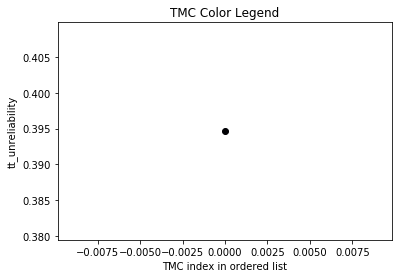

In [15]:
list1 = [float(filtered_df[df.tmc == feature['properties']['tmc']][COLUMN].values[0]) for feature in filtered_county_geojson['features']]
list2 = clrs

list3 = zip(list1, list2)  

list4 = [x for x in list3 if not isnan(x[0])]

list5 = sorted(list4, key = lambda t: t[0])

for i, (p,c) in enumerate(list5):
    plt.scatter(x=i,y=p, c=c)

plt.title('TMC Color Legend')
plt.ylabel(COLUMN)
plt.xlabel('TMC index in ordered list')

plt.show()

In [16]:
filtered_df

,tmc,days_in_sample,daily_occ_mean,daily_occ_stddev,daily_occ_quartiles,epochs_with_data_yr,epochs_in_tmc_date_range,travel_time_mean_yr,travel_time_stddev_yr,travel_time_quartiles_yr,...,speed_25th,speed_50th,speed_75th,speed_max,occ_min,occ_25th,occ_50th,occ_75th,occ_max,log_inv_occ_25th
638,120P50495,361,1.143,0.35,"{1,1,1,1,2}",8,60648,41.375,31.496,"{6,10,31,46,92}",...,1.252174,1.858065,5.76,9.6,1,1,1,1,2,0.0
